In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.precision', 2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
!pip install tabgan==1.3.3

### Load Python Packages

In [3]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.base import clone
from sklearn import set_config
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy.stats import randint, mode
from scipy.optimize import minimize

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, matthews_corrcoef, cohen_kappa_score

# Optuna and visualization tools
import optuna
USE_OPTUNA = False
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from matplotlib.colors import LinearSegmentedColormap

random_state = 42

SEED = 42
n_splits = 5

### First Look into Data

#### Check for missing values

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col=[0])
test_df  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col=[0])
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [5]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

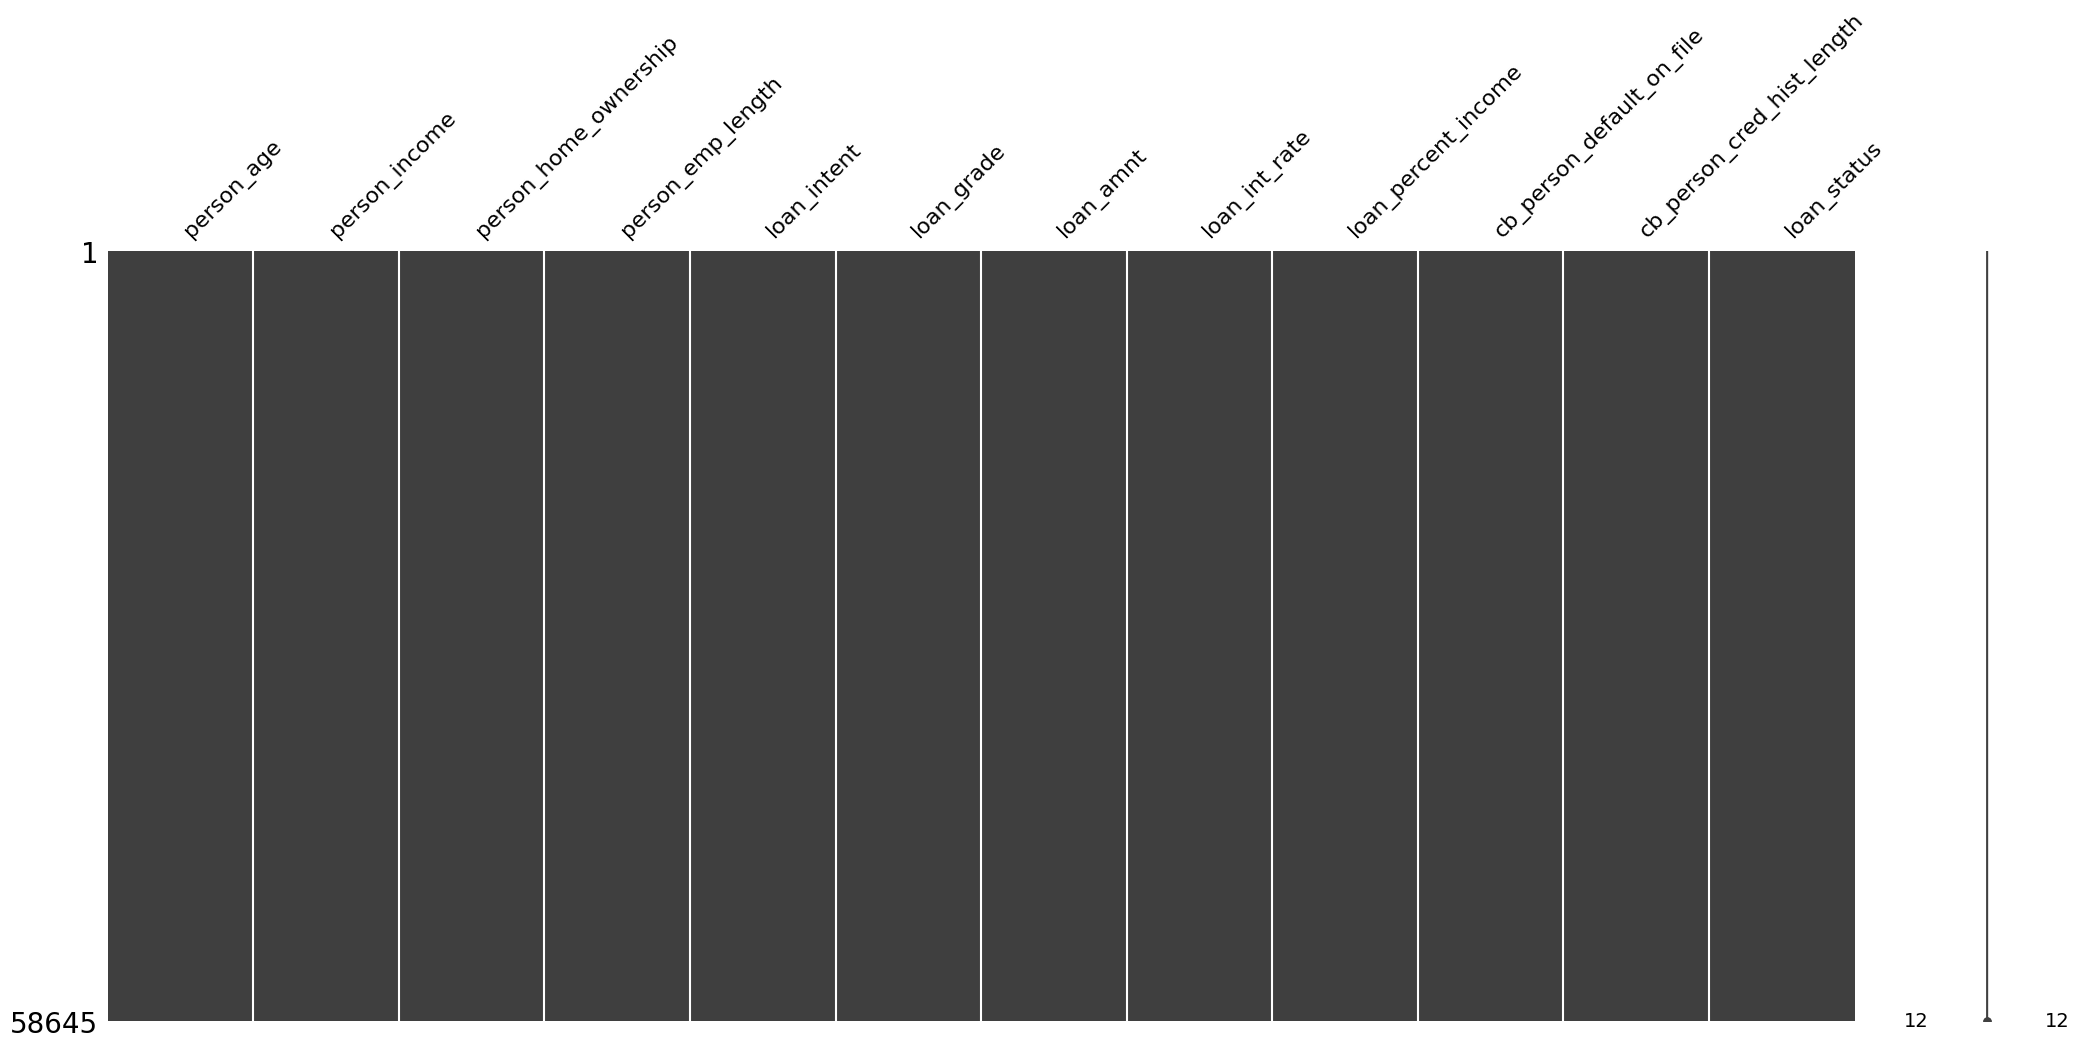

In [6]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [7]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent


### Descriptive statistics

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.55,6.03,20.00,23.00,26.00,30.00,1.23e+02
person_income,58645.0,64046.17,37931.11,4200.00,42000.00,58000.00,75600.00,1.90e+06
person_emp_length,58645.0,4.70,3.96,0.00,2.00,4.00,7.00,1.23e+02
loan_amnt,58645.0,9217.56,5563.81,500.00,5000.00,8000.00,12000.00,3.50e+04
loan_int_rate,58645.0,10.68,3.03,5.42,7.88,10.75,12.99,2.32e+01
loan_percent_income,58645.0,0.16,0.09,0.00,0.09,0.14,0.21,8.30e-01
cb_person_cred_hist_length,58645.0,5.81,4.03,2.00,3.00,4.00,8.00,3.00e+01
loan_status,58645.0,0.14,0.35,0.00,0.00,0.00,0.00,1.00e+00


### Grouping features for preprocessing purposes

In [9]:
train_df.nunique().sort_values()

cb_person_default_on_file        2
loan_status                      2
person_home_ownership            4
loan_intent                      6
loan_grade                       7
cb_person_cred_hist_length      29
person_emp_length               36
person_age                      53
loan_percent_income             61
loan_int_rate                  362
loan_amnt                      545
person_income                 2641
dtype: int64

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


### Feature Types

### Exploratory Data Analysis

In [11]:
categorical_fea = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_fea = train_df.select_dtypes(exclude=['object', 'category']).columns.tolist()

target_col = 'loan_status'

for feature in [target_col]:
    if feature in numerical_fea:
        numerical_fea.remove(feature)

# Create DataFrames for continuous and categorical variables

df_numerical = pd.DataFrame({'Numerical Variables': numerical_fea})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_fea})

print(df_numerical)
print(df_categorical)

          Numerical Variables
0                  person_age
1               person_income
2           person_emp_length
3                   loan_amnt
4               loan_int_rate
5         loan_percent_income
6  cb_person_cred_hist_length
       Categorical Variables
0      person_home_ownership
1                loan_intent
2                 loan_grade
3  cb_person_default_on_file


In [12]:
def stacked_bar_plot(df, feature, target=target_col):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
    plt.title(f'Stacked Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()

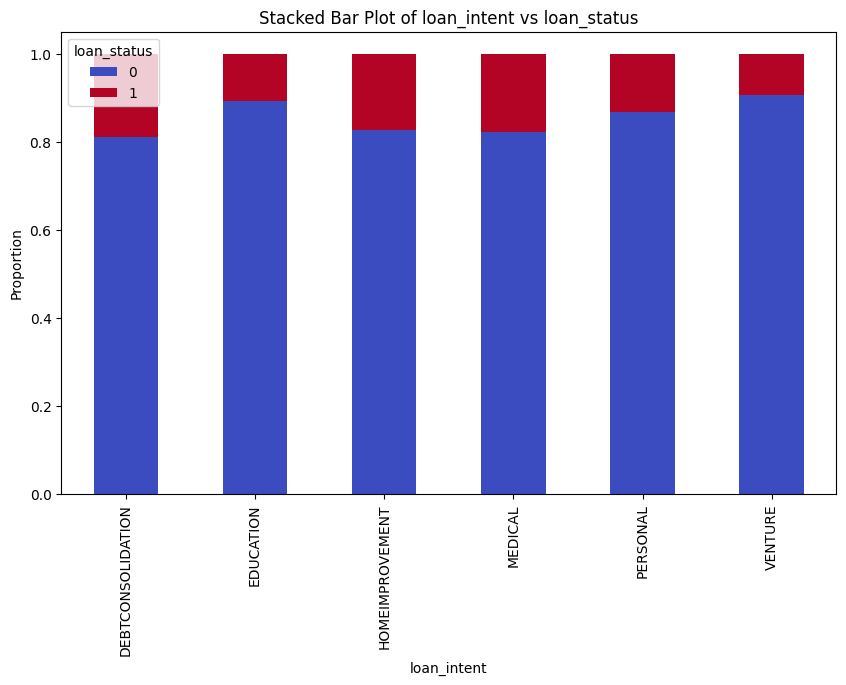

In [13]:
stacked_bar_plot(train_df, 'loan_intent')

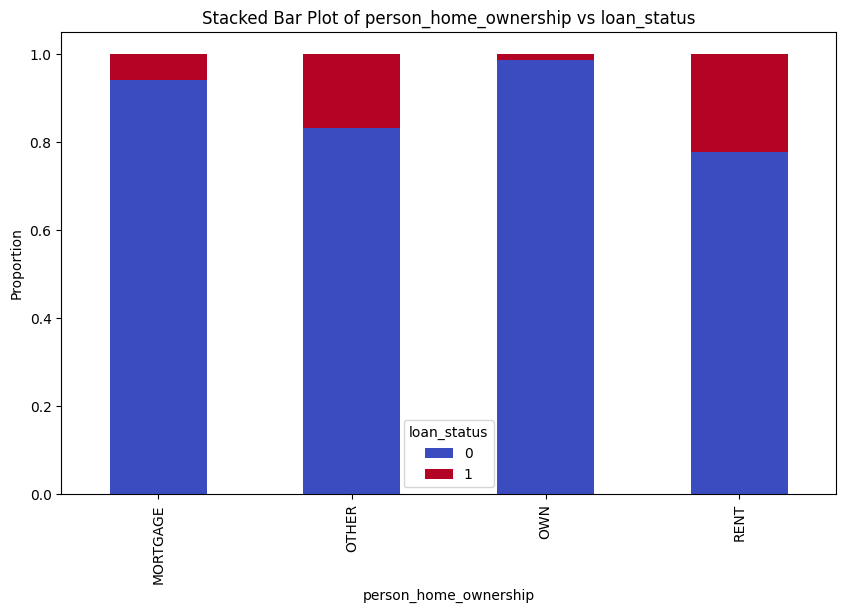

In [14]:
stacked_bar_plot(train_df, 'person_home_ownership')

In [15]:
def plot_histograms(df, columns):
    df[columns].hist(bins=20, figsize=(15, 10), color='skyblue')
    plt.suptitle('Histograms of Numerical Features', fontsize=16)
    plt.show()

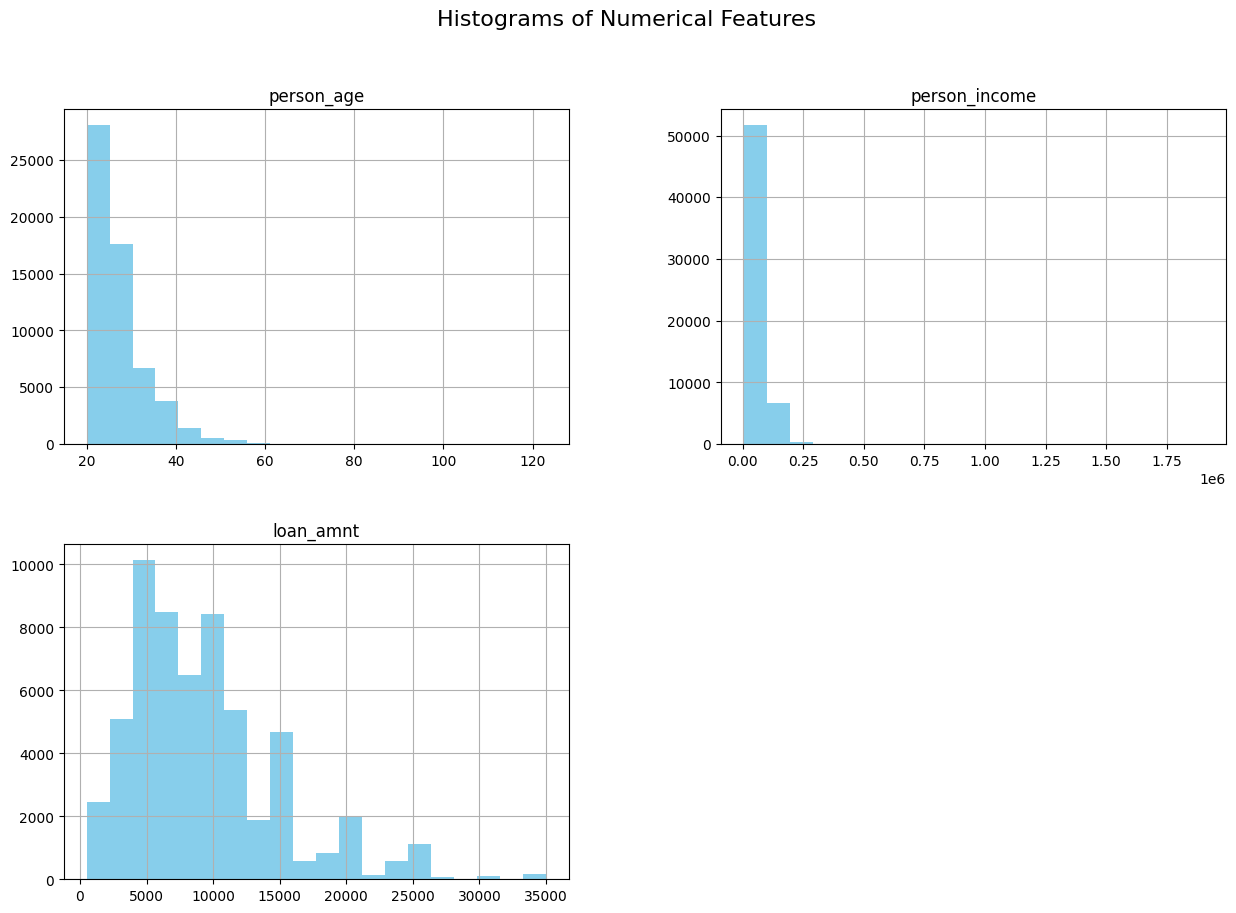

In [16]:
plot_histograms(train_df, ['person_age', 'person_income', 'loan_amnt'])

In [17]:
def plot_boxplots(df, columns):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y=df[col], color='lightblue')
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.show()

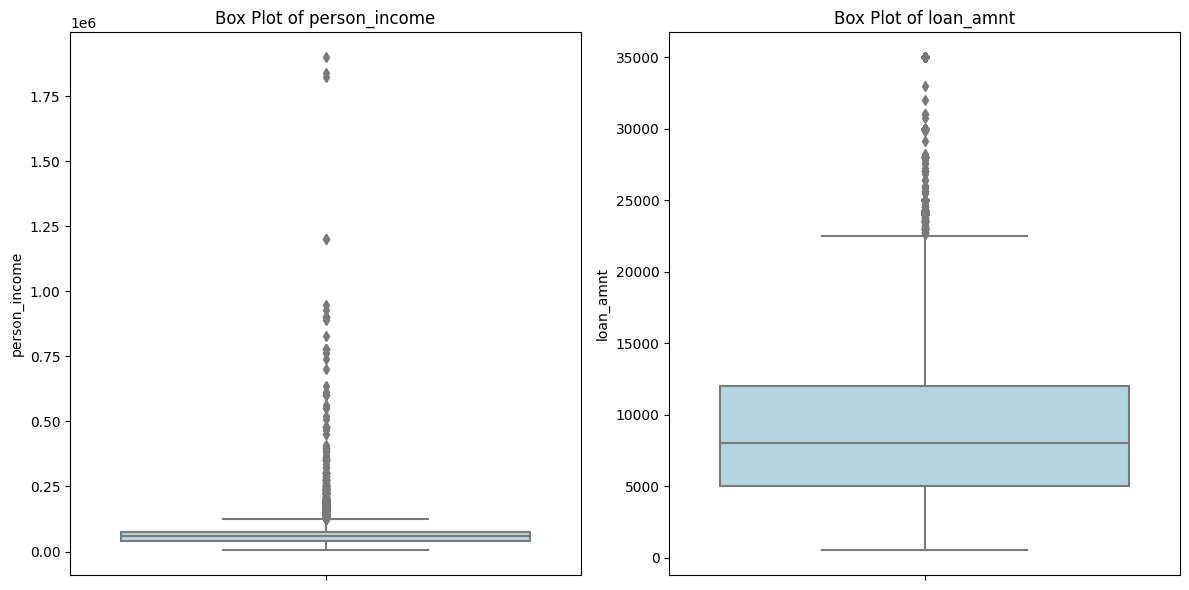

In [18]:
plot_boxplots(train_df, ['person_income', 'loan_amnt'])

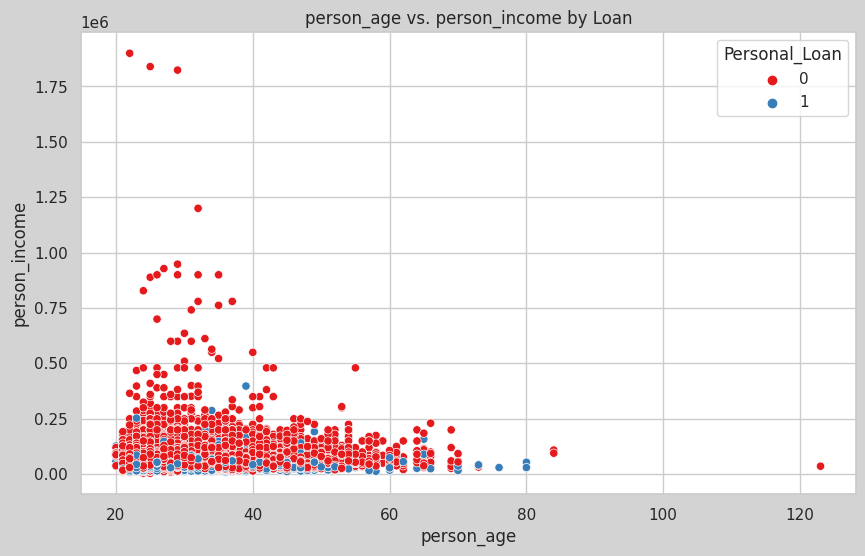

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='person_age', y='person_income', hue=target_col, palette='Set1')
plt.title('person_age vs. person_income by Loan')
plt.xlabel('person_age')
plt.ylabel('person_income')
plt.legend(title='Personal_Loan')
plt.gcf().set_facecolor('lightgrey') 
plt.show()

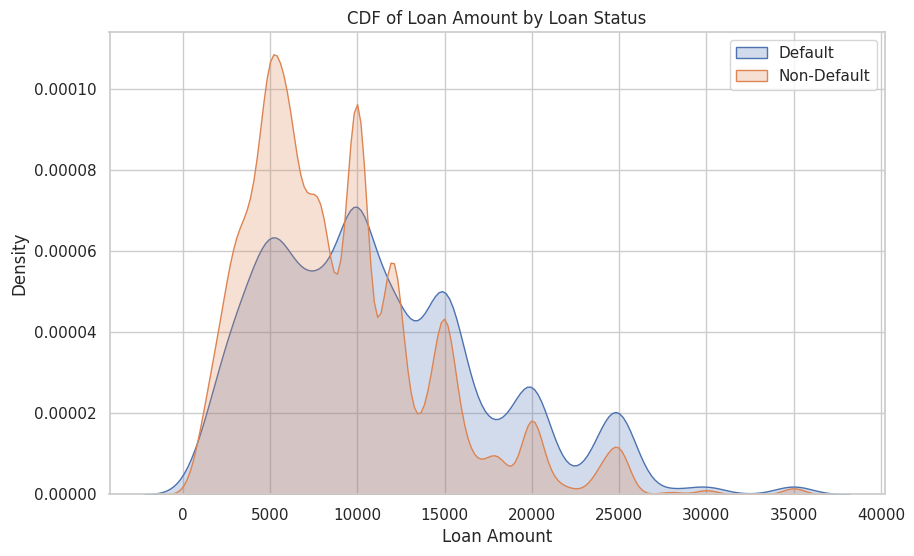

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df[train_df[target_col] == 1]['loan_amnt'], label='Default', fill=True)
sns.kdeplot(train_df[train_df[target_col] == 0]['loan_amnt'], label='Non-Default', fill=True)
plt.title('CDF of Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

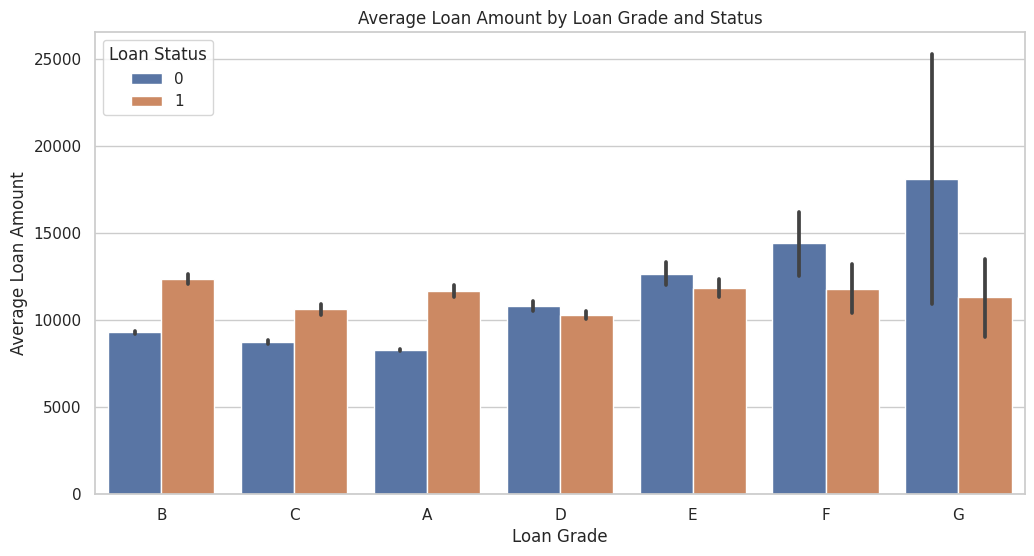

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x='loan_grade', y='loan_amnt', hue=target_col, data=train_df, estimator=np.mean)
plt.title('Average Loan Amount by Loan Grade and Status')
plt.xlabel('Loan Grade')
plt.ylabel('Average Loan Amount')
plt.legend(title='Loan Status')
plt.show()

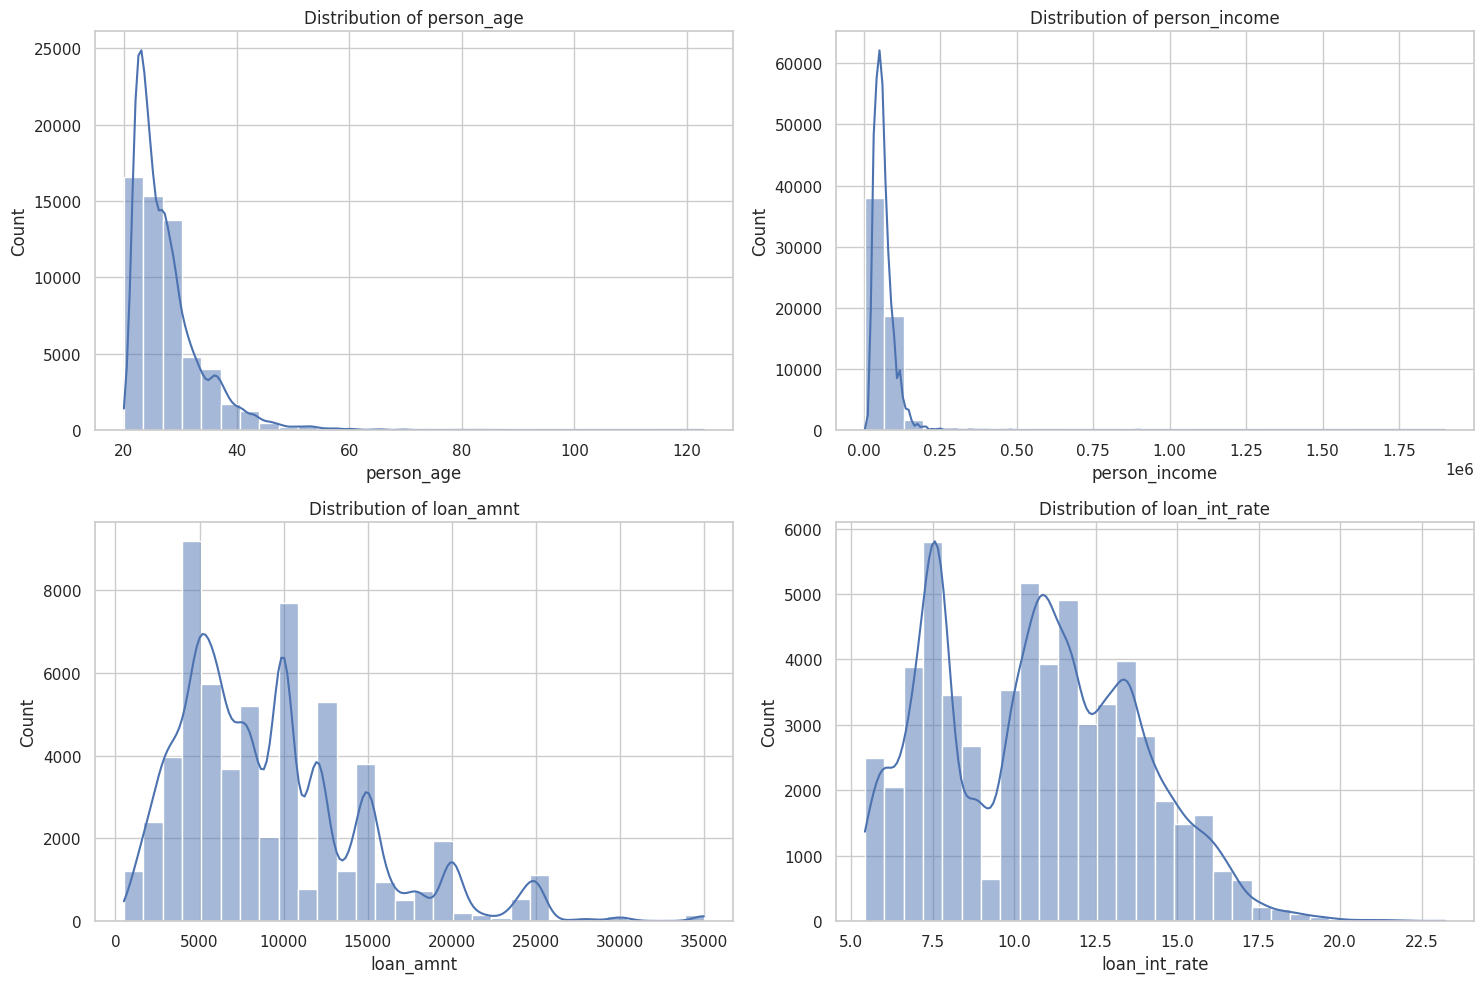

In [22]:
num_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

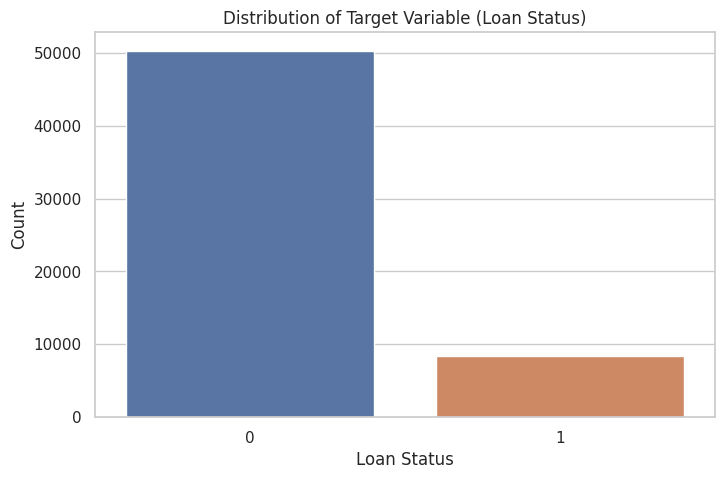

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=train_df)
plt.title('Distribution of Target Variable (Loan Status)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

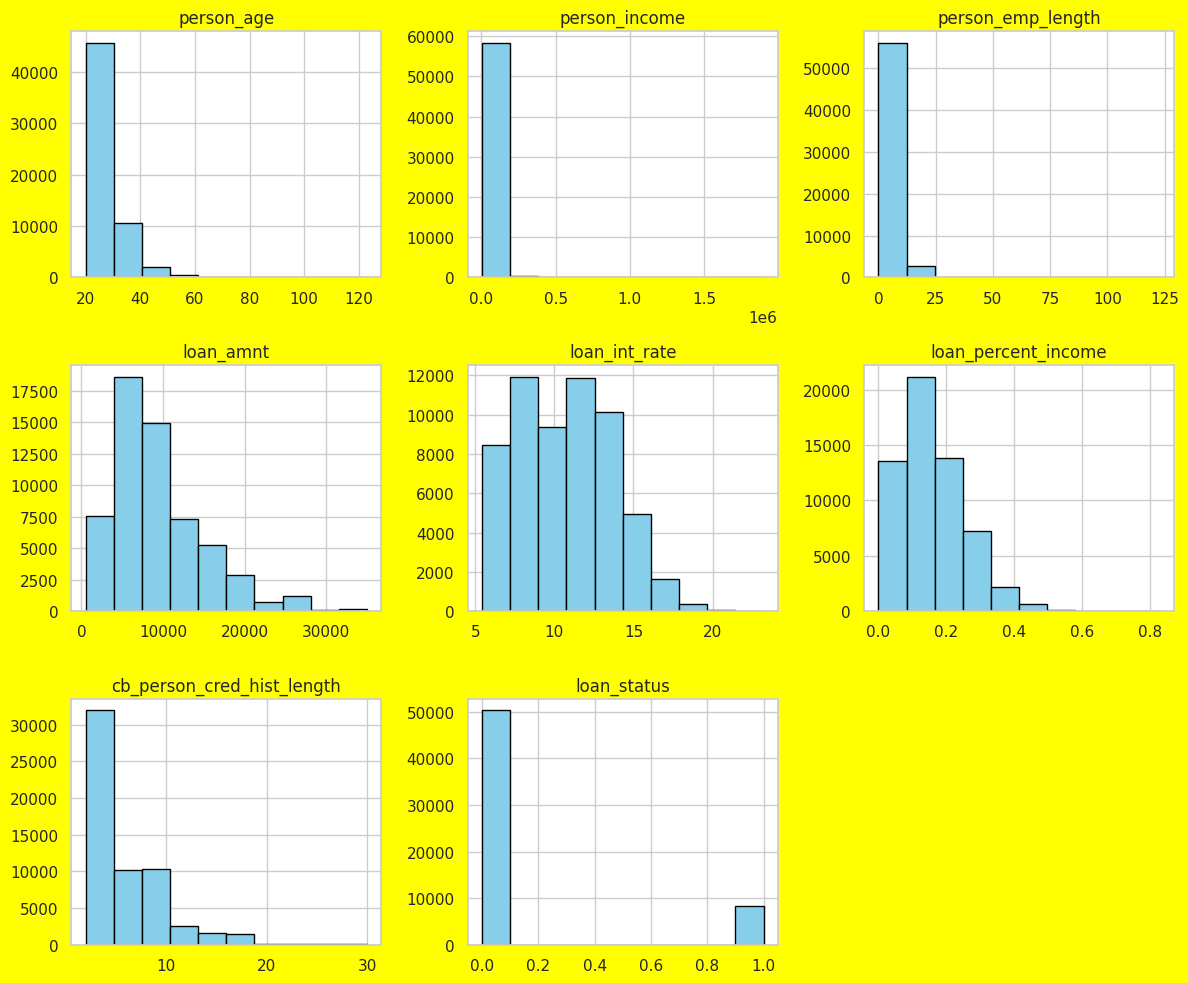

In [24]:
train_df.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.gcf().set_facecolor('yellow')
plt.tight_layout()
plt.show()

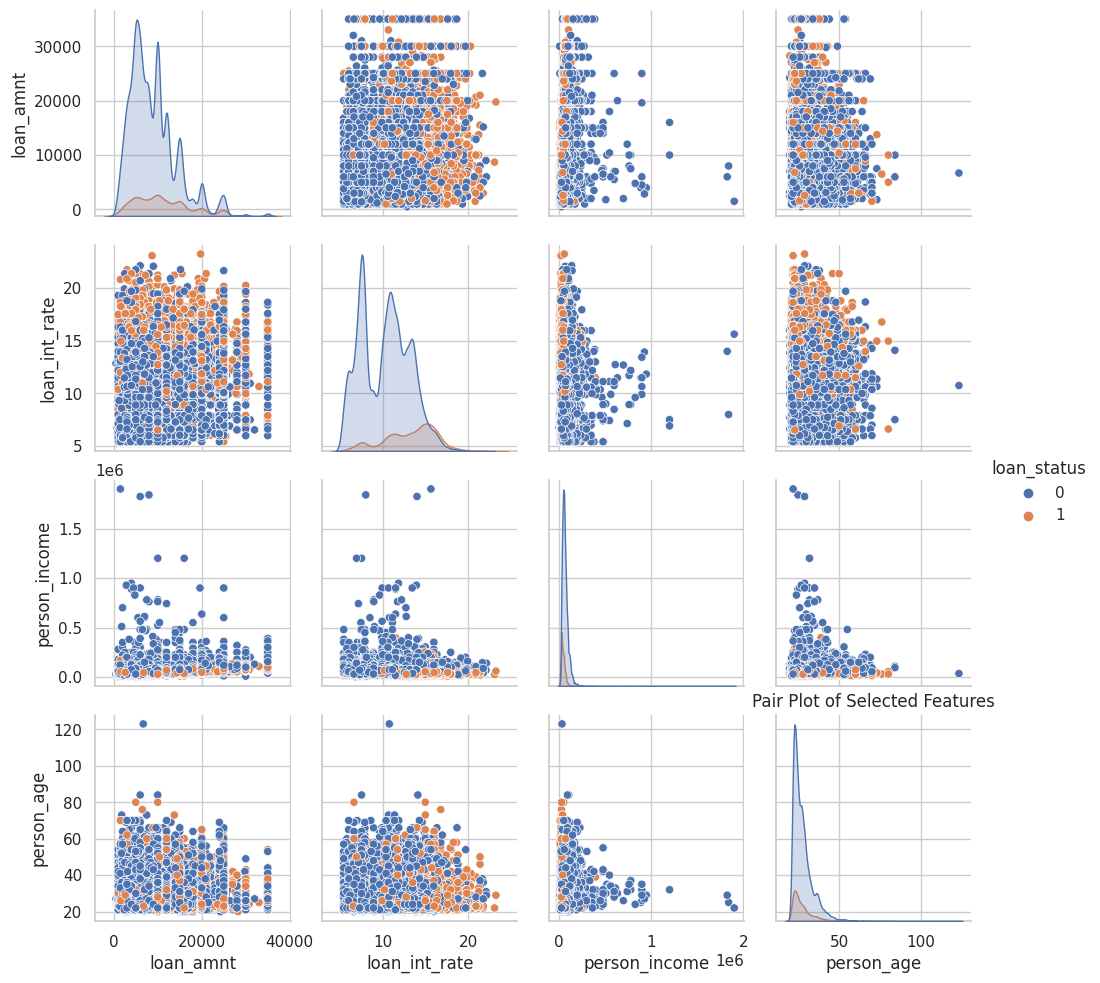

In [25]:
subset_features = ['loan_amnt', 'loan_int_rate', 'person_income', 'person_age', 'loan_status']
sns.pairplot(train_df[subset_features], hue=target_col)
plt.title('Pair Plot of Selected Features')
plt.show()

### Feature Engineering

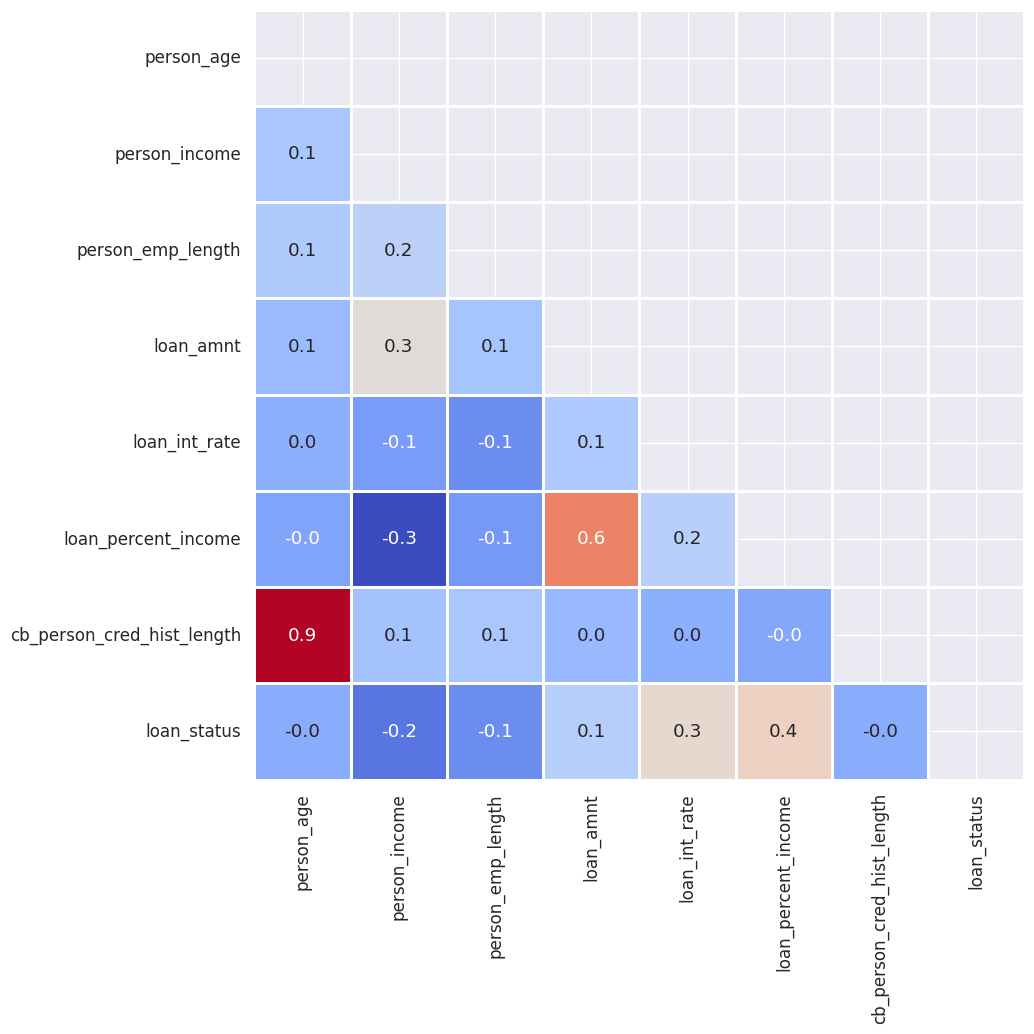

In [26]:
# Display correlations between numerical features and saleprice on heatmap.

sns.set(font_scale=1.1)
correlation_train = train_df[numerical_fea + ['loan_status']].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

In [27]:
# mutual information for numerical features
#You need to fillna to get results from mutual_info_regression function
mutual_df = train_df[numerical_fea]

mutual_info = mutual_info_regression(mutual_df.fillna(0), train_df['loan_status'], random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")

,Numerical_Feature_MI
person_income,0.101603
loan_int_rate,0.082275
loan_percent_income,0.080659
loan_amnt,0.007720
person_emp_length,0.007326
cb_person_cred_hist_length,0.003550
person_age,0.001338


In [28]:
#categorical features must be encoded to get mutual information
mutual_df_categorical = train_df[categorical_fea]

for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_regression(mutual_df_categorical.fillna("Missing"), train_df['loan_status'], random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
loan_grade,0.081045
person_home_ownership,0.031715
cb_person_default_on_file,0.009338
loan_intent,0.003020


### Encoding

In [29]:
def preprocess_data(df_train, df_test):  
    label_enc = LabelEncoder()   
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']    
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_train[col] = df_train[col].astype('int32')
        df_test[col] = label_enc.transform(df_test[col])  
        df_test[col] = df_test[col].astype('int32')
    df_train = pd.get_dummies(df_train, columns=['loan_intent'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['loan_intent'], drop_first=True) 
    target_col = 'loan_status'
    train_columns = df_train.drop(columns=[target_col]).columns    
    df_test = df_test.reindex(columns=train_columns, fill_value=0)    
    return df_train, df_test

In [30]:
train_df_processed, test_df_processed = preprocess_data(train_df, test_df)

In [31]:
train_df = train_df_processed
test_df = test_df_processed

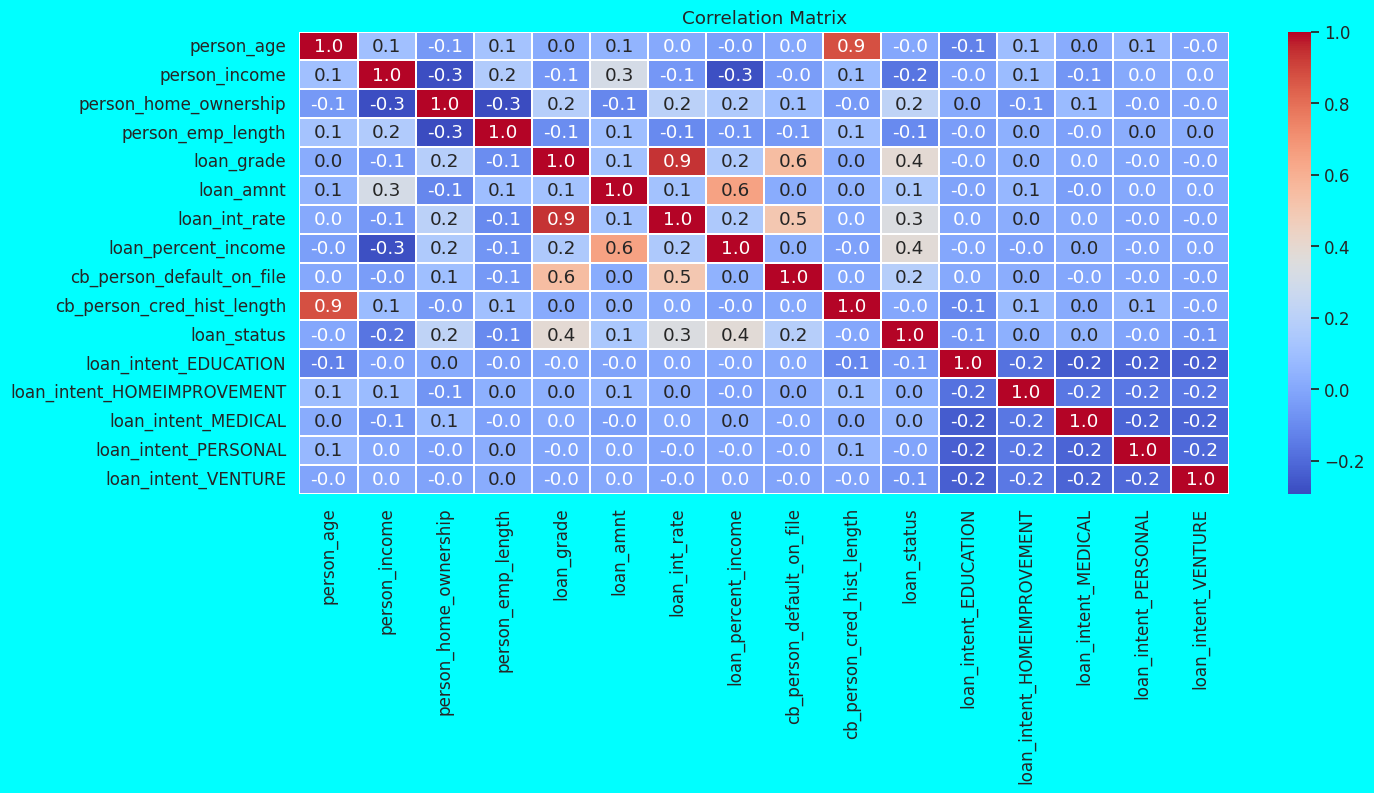

In [32]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)
plt.gcf().set_facecolor('#00FFFF')  
plt.title('Correlation Matrix')
plt.show()

In [33]:
y = train_df[target_col] 
train_df = train_df.drop([target_col],axis=1)
X = train_df

### Scaling

In [34]:
scaler = StandardScaler()
train_df[numerical_fea] = scaler.fit_transform(train_df[numerical_fea])
test_df[numerical_fea] = scaler.transform(test_df[numerical_fea])

In [35]:
#scaler = StandardScaler()
#scaled_train_data = train_df
#scaled_test_data = test_df

In [36]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

### XGBoost

In [37]:
xgb_params = {
    'n_estimators': 600,
    'max_depth': 10,
    'learning_rate': 0.06,
    'random_state': 42,
    
    'eval_metric': 'auc'
}

In [38]:
xgb_predictions = np.zeros(len(train_df))
xgb_true_labels = np.zeros(len(train_df))
xgb_test_predictions = np.zeros(len(test_df))

In [39]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y)):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBClassifier(**xgb_params)

    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=10,
                  verbose=100)
    xgb_fold_preds = xgb_model.predict_proba(X_val)[:, 1] 
    xgb_fold_test_preds = xgb_model.predict_proba(test_df)[:, 1]
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits

overall_auc_xgb = roc_auc_score(xgb_true_labels, xgb_predictions)
print("Overall AUC (XGBClassifier):", overall_auc_xgb)

[0]	validation_0-auc:0.93917	validation_1-auc:0.92972
[100]	validation_0-auc:0.98755	validation_1-auc:0.95465
[104]	validation_0-auc:0.98800	validation_1-auc:0.95473
[0]	validation_0-auc:0.93871	validation_1-auc:0.92480
[100]	validation_0-auc:0.98927	validation_1-auc:0.95079
[114]	validation_0-auc:0.99130	validation_1-auc:0.95091
[0]	validation_0-auc:0.94169	validation_1-auc:0.92711
[100]	validation_0-auc:0.98925	validation_1-auc:0.94973
[114]	validation_0-auc:0.99101	validation_1-auc:0.94959
[0]	validation_0-auc:0.93931	validation_1-auc:0.93020
[100]	validation_0-auc:0.98845	validation_1-auc:0.95351
[144]	validation_0-auc:0.99251	validation_1-auc:0.95466
[0]	validation_0-auc:0.94189	validation_1-auc:0.91645
[100]	validation_0-auc:0.98939	validation_1-auc:0.94213
[164]	validation_0-auc:0.99489	validation_1-auc:0.94392
Overall AUC (XGBClassifier): 0.9504725949234843


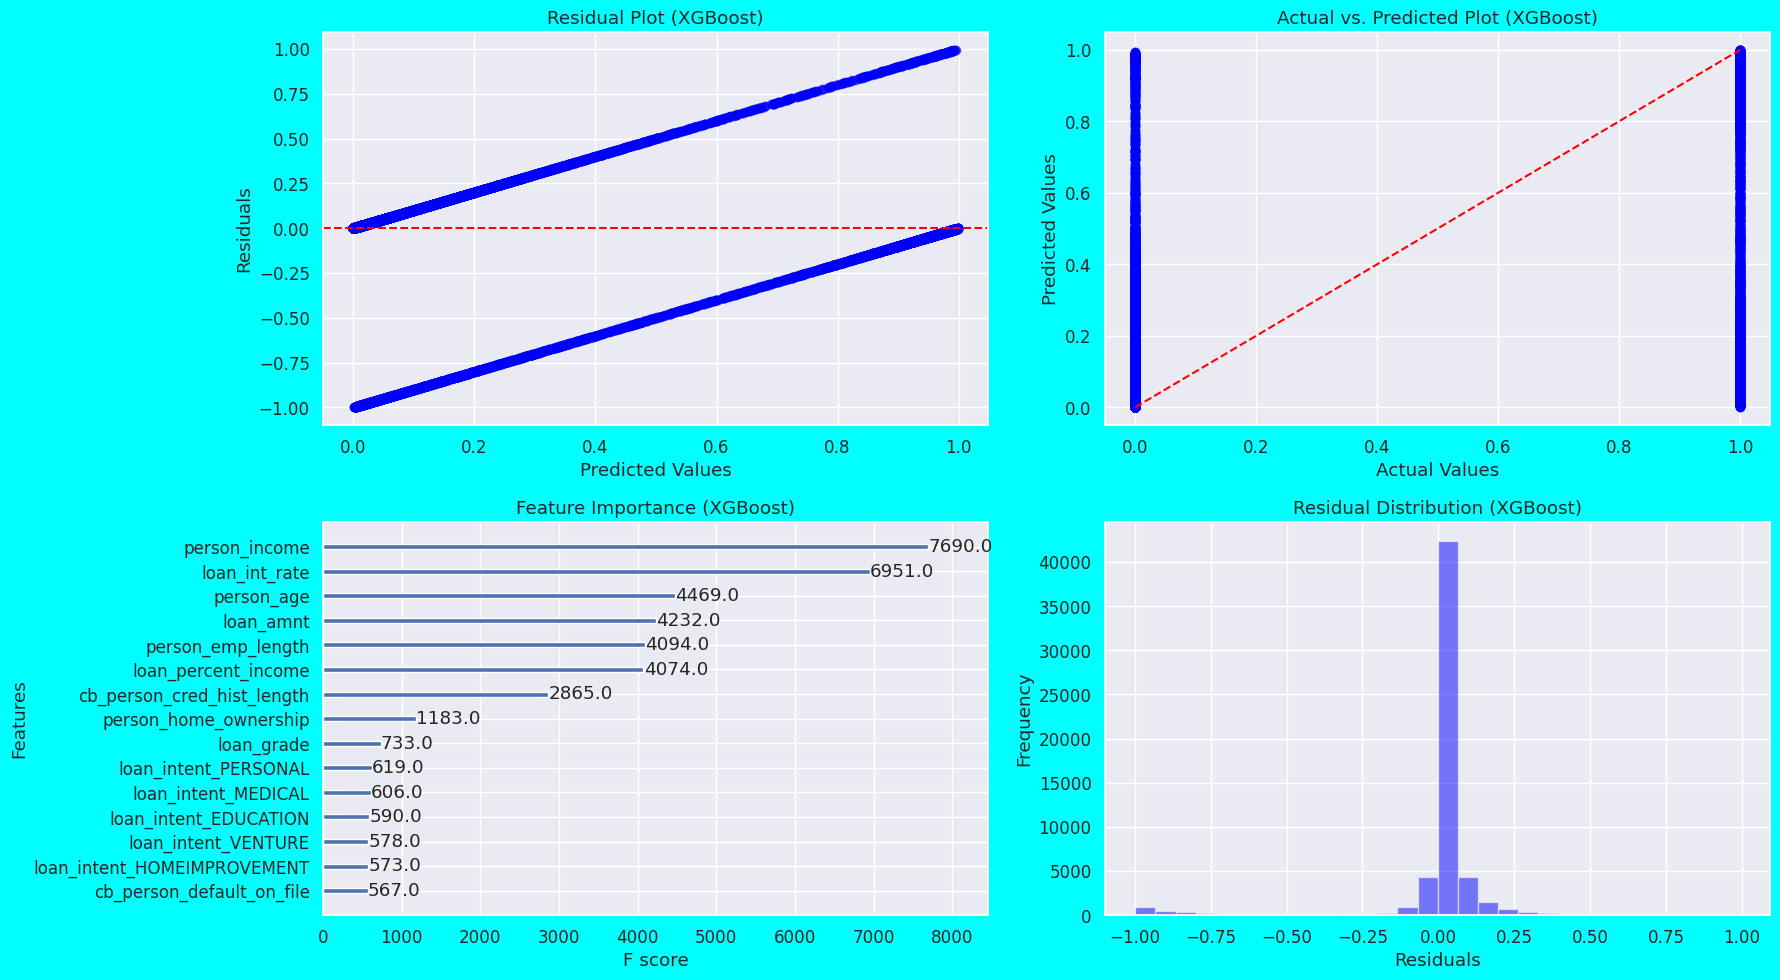

In [40]:
from xgboost import plot_importance

xgb_residuals = xgb_predictions - xgb_true_labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axes[0, 0].scatter(xgb_predictions, xgb_residuals, color='blue', alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot (XGBoost)')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)

axes[0, 1].scatter(xgb_true_labels, xgb_predictions, color='blue', alpha=0.5)
axes[0, 1].plot([min(xgb_true_labels), max(xgb_true_labels)], [min(xgb_true_labels), max(xgb_true_labels)], color='red', linestyle='--')
axes[0, 1].set_title('Actual vs. Predicted Plot (XGBoost)')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True)

plot_importance(xgb_model, ax=axes[1, 0])
axes[1, 0].set_title('Feature Importance (XGBoost)')

axes[1, 1].hist(xgb_residuals, bins=30, color='blue', alpha=0.5)
axes[1, 1].set_title('Residual Distribution (XGBoost)')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.gcf().set_facecolor('cyan')
plt.tight_layout()
plt.show()

### Catboost

In [41]:
catboost_params = {
    'loss_function':'Logloss',
        'eval_metric':'AUC',
        'learning_rate':0.05,
        'iterations':5000,
        'depth':12,        
        'l2_leaf_reg':0.6, 
}

In [42]:
catboost_predictions = np.zeros(len(train_df))
catboost_true_labels = np.zeros(len(train_df))
catboost_test_predictions = np.zeros(len(test_df))

In [43]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y)):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    catboost_model = CatBoostClassifier(**catboost_params)

    catboost_model.fit(X_train, y_train,
                       eval_set=(X_val, y_val),
                       early_stopping_rounds=10,
                       verbose=False)
  
    catboost_fold_preds = catboost_model.predict_proba(X_val)[:, 1] 
    catboost_fold_test_preds = catboost_model.predict_proba(test_df)[:, 1]

    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val
    catboost_test_predictions += catboost_fold_test_preds / n_splits

overall_metric_catboost = roc_auc_score(catboost_true_labels, catboost_predictions)
print("Overall AUC (CatBoostClassifier):", overall_metric_catboost)

Overall AUC (CatBoostClassifier): 0.9382412080104627


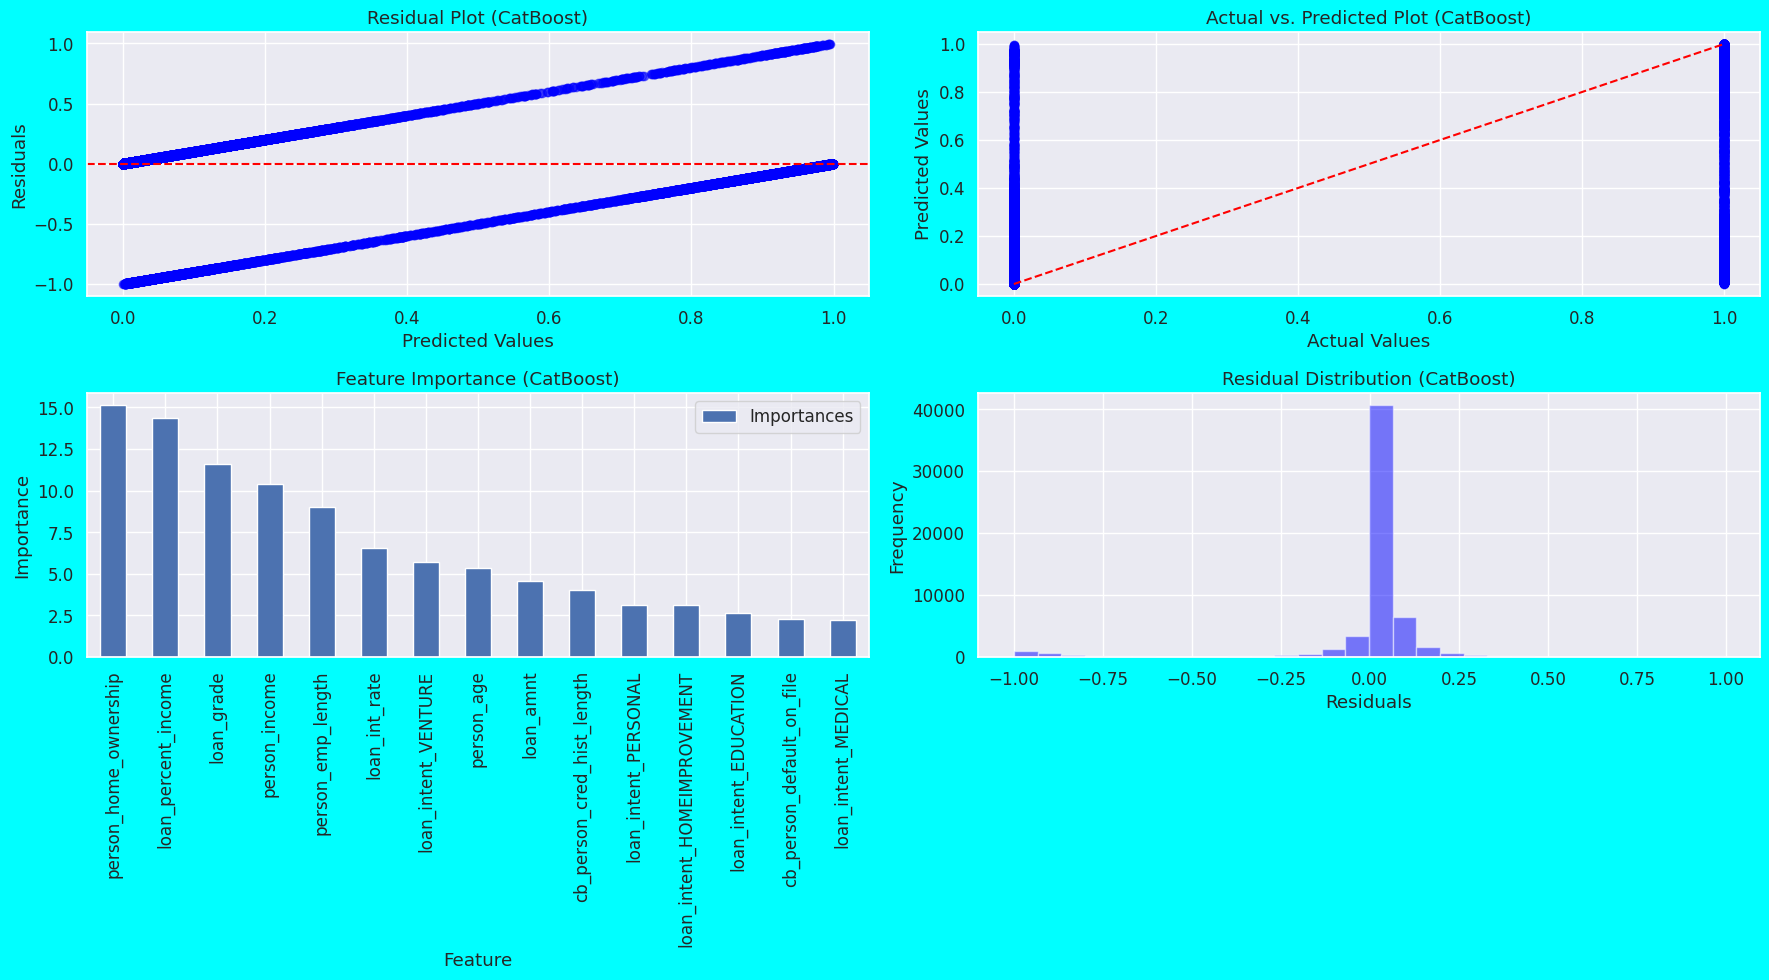

In [44]:
catboost_residuals = catboost_predictions - catboost_true_labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axes[0, 0].scatter(catboost_predictions, catboost_residuals, color='blue', alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot (CatBoost)')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)

axes[0, 1].scatter(catboost_true_labels, catboost_predictions, color='blue', alpha=0.5)
axes[0, 1].plot([min(catboost_true_labels), max(catboost_true_labels)], [min(catboost_true_labels), max(catboost_true_labels)], color='red', linestyle='--')
axes[0, 1].set_title('Actual vs. Predicted Plot (CatBoost)')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True)

catboost_model.get_feature_importance(prettified=True).plot(kind='bar', x='Feature Id', y='Importances', ax=axes[1, 0])
axes[1, 0].set_title('Feature Importance (CatBoost)')
axes[1, 0].set_xlabel('Feature')
axes[1, 0].set_ylabel('Importance')

axes[1, 1].hist(catboost_residuals, bins=30, color='blue', alpha=0.5)
axes[1, 1].set_title('Residual Distribution (CatBoost)')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)
plt.gcf().set_facecolor('cyan')
plt.tight_layout()
plt.show()

### LGBM

In [45]:
lgb_params = {
    'objective': 'binary',
        'n_estimators': 3000,
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate':0.0322942967545754,
        'num_leaves': 24,
        'max_depth': 15,
        'min_data_in_leaf': 25,
        'feature_fraction': 0.6236144085285287,
        'bagging_fraction': 0.9596685778433888,
        'bagging_freq': 3,      
        'verbose' : -1
}

In [48]:
lgbm_predictions = np.zeros(len(train_df))
lgbm_true_labels = np.zeros(len(train_df))
lgbm_test_predictions = np.zeros(len(test_df))

callbacks = [early_stopping(stopping_rounds=10)]

In [50]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y)):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]  
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='auc',  
                   callbacks=callbacks)#,
                   #verbose=False)
    
    lgbm_fold_preds = lgbm_model.predict_proba(X_val)[:, 1]  
    lgbm_fold_test_preds = lgbm_model.predict_proba(test_df)[:, 1]
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits

overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier):", overall_metric_lgbm)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[292]	valid_0's auc: 0.958395	valid_0's binary_logloss: 0.14818
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[332]	valid_0's auc: 0.958041	valid_0's binary_logloss: 0.150184
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.955009	valid_0's binary_logloss: 0.151757
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.960788	valid_0's binary_logloss: 0.144744
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[341]	valid_0's auc: 0.951709	valid_0's binary_logloss: 0.155743
Overall AUC (LGBMClassifier): 0.9567037139559236


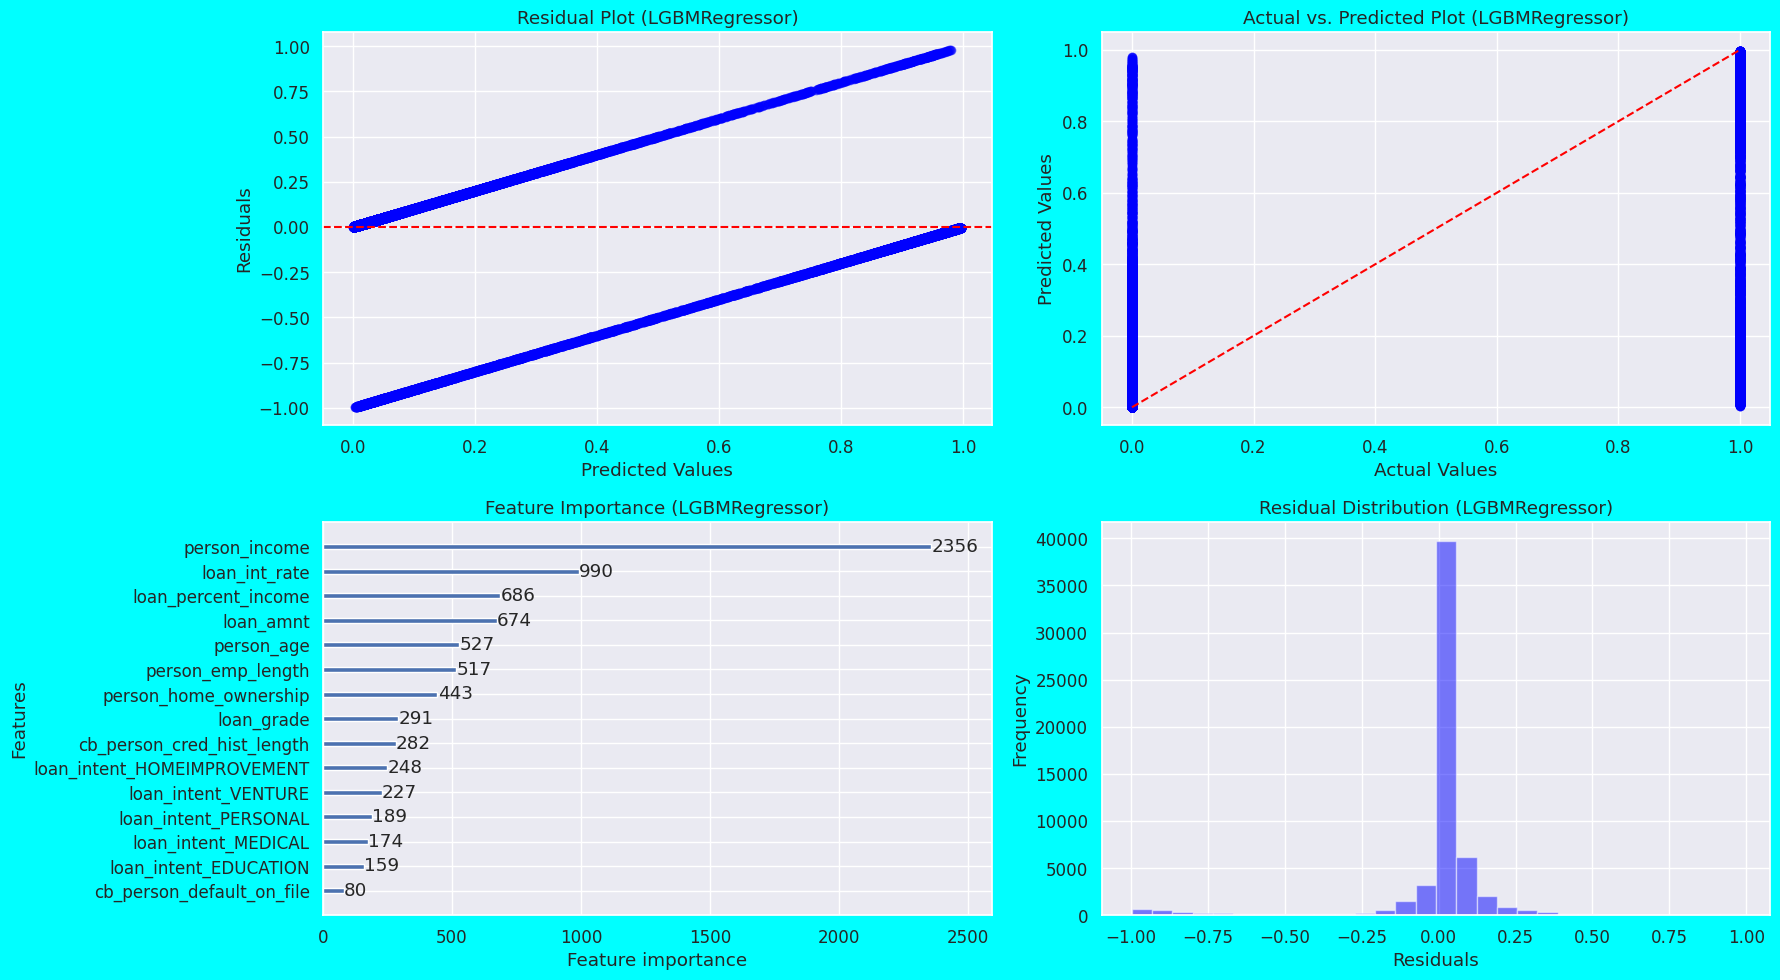

In [51]:
from lightgbm import plot_importance

lgbm_residuals = lgbm_predictions - lgbm_true_labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axes[0, 0].scatter(lgbm_predictions, lgbm_residuals, color='blue', alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot (LGBMRegressor)')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)

axes[0, 1].scatter(lgbm_true_labels, lgbm_predictions, color='blue', alpha=0.5)
axes[0, 1].plot([min(lgbm_true_labels), max(lgbm_true_labels)], [min(lgbm_true_labels), max(lgbm_true_labels)], color='red', linestyle='--')
axes[0, 1].set_title('Actual vs. Predicted Plot (LGBMRegressor)')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True)

plot_importance(lgbm_model, ax=axes[1, 0], figsize=(10, 6))
axes[1, 0].set_title('Feature Importance (LGBMRegressor)')

axes[1, 1].hist(lgbm_residuals, bins=30, color='blue', alpha=0.5)
axes[1, 1].set_title('Residual Distribution (LGBMRegressor)')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)
plt.gcf().set_facecolor('#00FFFF')
plt.tight_layout()
plt.show()

In [52]:
sample_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


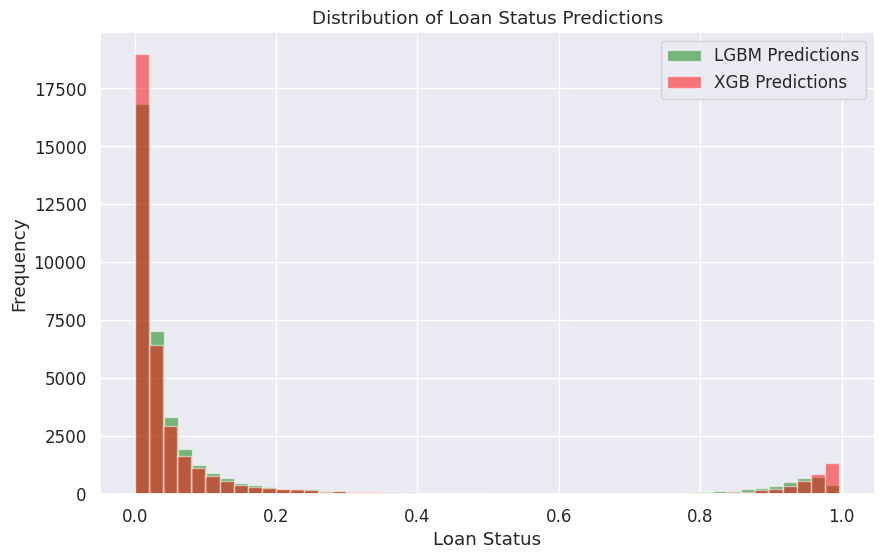

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(lgbm_test_predictions, bins=50, alpha=0.5, color='green', label='LGBM Predictions')
plt.hist(xgb_test_predictions, bins=50, alpha=0.5, color='red', label='XGB Predictions')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Status Predictions')
plt.legend()
plt.show()

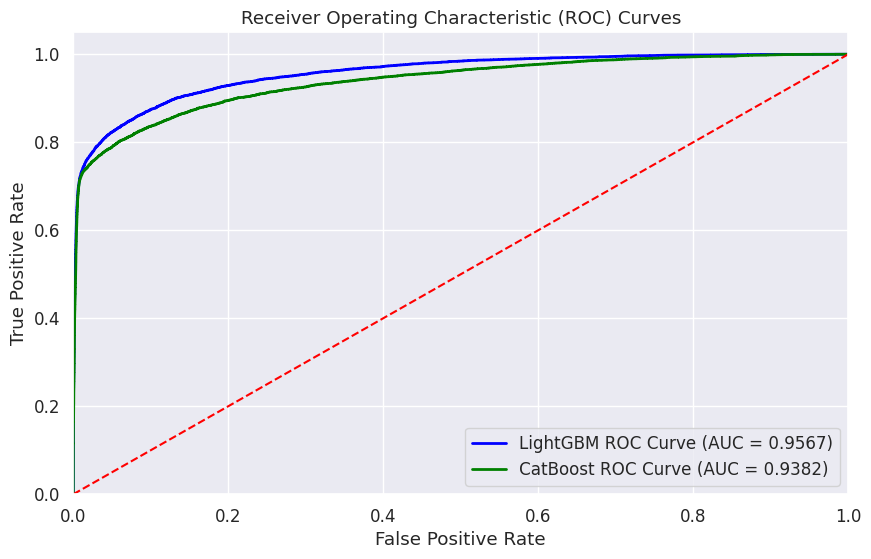

In [54]:
fpr_lgbm, tpr_lgbm, _ = roc_curve(lgbm_true_labels, lgbm_predictions)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_catboost, tpr_catboost, _ = roc_curve(catboost_true_labels, catboost_predictions)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_catboost, tpr_catboost, color='green', lw=2, label=f'CatBoost ROC Curve (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [55]:
sample_sub['loan_status'] = lgbm_test_predictions*0.45 + catboost_test_predictions*0.1 + xgb_test_predictions*0.45

In [56]:
sample_sub.head()

,id,loan_status
0,58645,0.99
1,58646,0.02
2,58647,0.61
3,58648,0.01
4,58649,0.10


In [57]:
sample_sub.to_csv('submission.csv', index=False)